In [1]:
import math 
import pandas as pd 
import torch 
from torch import nn 
from d2l import torch as d2l 

基于位置的前馈网络<br>
它对于序列中的所有位置的表示进行变换时使用的是同一个多层感知机

In [2]:
class PositionWiseFFN(nn.Module):
    """基于位置的前馈网络"""
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs, **kwargs):
        super(PositionWiseFFN, self).__init__(**kwargs)
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)
    
    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))

In [ ]:
ffn = PositionWiseFFN(4, 4, 8) # 4 ffn_num_input
ffn.eval()
ffn(torch.ones((2, 3, 4)))[0]

tensor([[-0.0787, -0.5071,  0.2343, -0.5452,  0.3062, -0.1911, -0.0047,  0.3526],
        [-0.0787, -0.5071,  0.2343, -0.5452,  0.3062, -0.1911, -0.0047,  0.3526],
        [-0.0787, -0.5071,  0.2343, -0.5452,  0.3062, -0.1911, -0.0047,  0.3526]],
       grad_fn=<SelectBackward0>)

残差连接和层规范化

层规范化：单个样本的所有特征，进行规范化<br>
批量规范化：该批量内，同一特征在苏不同样本间，进行规范化

In [ ]:
ln = nn.LayerNorm(2)    # 2 特征维度
bn = nn.BatchNorm1d(2)  # 2 特征维度
X = torch.tensor([[1, 2], [2, 3]], dtype=torch.float32)
# 在训练模式下计算X的均值和方差
print('layer norm:', ln(X), '\nbatch norm:', bn(X))

layer norm: tensor([[-1.0000,  1.0000],
        [-1.0000,  1.0000]], grad_fn=<NativeLayerNormBackward0>) 
batch norm: tensor([[-1.0000, -1.0000],
        [ 1.0000,  1.0000]], grad_fn=<NativeBatchNormBackward0>)


In [12]:
class AddNorm(nn.Module):
    """残差连接后进行层规范化"""
    def __init__(self, normalized_shape, dropout, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(normalized_shape)
    
    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)

In [13]:
# 残差连接要求两个输入的形状相同，以便加法操作后输出张量的形状相同
add_norm = AddNorm([3, 4], 0.5)
add_norm.eval()
add_norm(torch.ones((2, 3, 4)), torch.ones((2, 3, 4))).shape

torch.Size([2, 3, 4])

编码器

In [14]:
class EncoderBlock(nn.Module):
    """Transformer编码器块, 实现了多头自注意力和基于位置的前馈网络"""
    def __init__(self, key_size, query_size, value_size, num_hiddens, norm_shape,
                 ffn_num_input, ffn_num_hiddens, num_heads, dropout, use_bias=False, **kwargs):
        super(EncoderBlock, self).__init__(**kwargs)
        # 多头自注意力层
        self.attention = d2l.MultiHeadAttention(key_size, query_size, value_size, num_hiddens, num_heads, dropout, use_bias)
        # 紧跟残差连接和层规范化
        self.addnorm1 = AddNorm(norm_shape, dropout)
        # 基于位置的前馈网络
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(norm_shape, dropout)
    
    def forward(self, X, valid_lens):
        # X与输出相加，实现残差连接
        # attention(X, X, X)实现自注意力
        # addnorm连接残差，并进行层规范化
        Y = self.addnorm1(X, self.attention(X, X, X, valid_lens))
        return self.addnorm2(Y, self.ffn(Y))

In [15]:
X = torch.ones(2, 100, 24)
valid_lens = torch.tensor([3, 2])
encoder_blk = EncoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5)
encoder_blk.eval()
encoder_blk(X, valid_lens).shape

torch.Size([2, 100, 24])

In [35]:
class TransformerEncoder(d2l.Encoder):
    """Transformer编码器, 堆叠了num_layers个EncoderBlock类的实例"""
    def __init__(self, vocab_size, key_size, query_size, value_size, num_hiddens, norm_shape, 
                 ffn_num_input, ffn_num_hiddens, num_heads, num_layers, dropout, use_bias=False, **kwargs):
        super(TransformerEncoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.embedding = nn.Embedding(vocab_size, num_hiddens) # 嵌入层
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout) # 位置编码
        self.blks = nn.Sequential()  # 编码器块
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                EncoderBlock(key_size, query_size, value_size, num_hiddens, norm_shape,
                             ffn_num_input, ffn_num_hiddens, num_heads, dropout, use_bias))
    
    def forward(self, X, valid_lens, *args):
        # 因为位置编码值范围在-1~1，所以嵌入值乘以嵌入维度的平方根进行缩放，再与位置编码相加
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self.attention_weights = [None] * len(self.blks) 
        for i, blk in enumerate(self.blks):
            X = blk(X, valid_lens)
            self.attention_weights[i] = blk.attention.attention.attention_weights 
        return X 

In [ ]:
encoder = TransformerEncoder(200, 24, 24, 24, 24, [100, 24], 24, 48, 8, 2, 0.5)
encoder.eval()
# (批量大小，时间步数，num_hiddens)
encoder(torch.ones((2, 100), dtype=torch.long), valid_lens).shape

torch.Size([2, 100, 24])

解码器

In [ ]:
class DecoderBlock(nn.Module):
    """解码器中第i个块"""
    def __init__(self, key_size, query_size, value_size, num_hiddens, norm_shape,
                 ffn_num_input, ffn_num_hiddens, num_heads, dropout, i, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        self.i = i 
        # 解码器自注意力
        self.attention1 = d2l.MultiHeadAttention(key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        # 编码器-解码器注意力
        self.attention2 = d2l.MultiHeadAttention(key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm2 = AddNorm(norm_shape, dropout)
        # 基于位置的前馈网络
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm3 = AddNorm(norm_shape, dropout)

    def forward(self, X, state):
        enc_outputs, enc_valid_lens = state[0], state[1]
        # 训练阶段，输出序列的所有词元都在同一时间处理
        # 因此state[2][self.i]初始化为None
        # 预测阶段，输出序列是通过词元一个接着一个解码的 
        # 因此state[2][self.i]包含直到当前时间步第i个块解码的输出表示
        if state[2][self.i] is None:
            keys_values = X 
        else:
            keys_values = torch.cat((state[2][self.i], X), axis=1)
        state[2][self.i] = keys_values
        if self.training:  # 训练阶段
            batch_size, num_steps, _ = X.shape
            # dec_valid_lens的开头:(batch_size, num_steps)
            # 其中每一行是[1, 2, ..., num_steps]
            dec_valid_lens = torch.arange(1, num_steps+1, device=X.device).repeat(batch_size, 1)
        else:              # 预测阶段
            dec_valid_lens = None 
        
        # 解码器自注意力
        X2 = self.attention1(X, keys_values, keys_values, dec_valid_lens)
        Y = self.addnorm1(X, X2)
        # 编码器-解码器注意力
        # enc_outputs的开头:(batch_size, num_steps, num_hiddens)
        Y2 = self.attention2(Y, enc_outputs, enc_outputs, enc_valid_lens)
        Z = self.addnorm2(Y, Y2)
        return self.addnorm3(Z, self.ffn(Z)), state

torch.Size([2, 100, 24])

In [25]:
decoder_blk = DecoderBlock(24, 24, 24, 24, [100, 24], 24, 48, 8, 0.5, 0)
decoder_blk.eval()
X = torch.ones((2, 100, 24))
state = [encoder_blk(X, valid_lens), valid_lens, [None]]
decoder_blk(X, state)[0].shape

torch.Size([2, 100, 24])

In [26]:
# 将解码器自注意力权重和编码器-解码器注意力权重存储下来，便于可视化
class TransformerDecoder(d2l.AttentionDecoder):
    def __init__(self, vocab_size, key_size, query_size, value_size, num_hiddens, norm_shape, 
                 ffn_num_input, ffn_num_hiddens, num_heads, num_layers, dropout, **kwargs):
        super(TransformerDecoder, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, num_hiddens)            # 嵌入层
        self.pos_encoding = d2l.PositionalEncoding(num_hiddens, dropout)  # 位置编码
        self.blks = nn.Sequential() # 块
        for i in range(num_layers):
            self.blks.add_module("block" + str(i),
                DecoderBlock(key_size, query_size, value_size, num_hiddens, norm_shape, 
                             ffn_num_input, ffn_num_hiddens, num_heads, dropout, i))
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        return [enc_outputs, enc_valid_lens, [None] * self.num_layers]
    
    def forward(self, X, state):
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))
        self._attention_weights = [[None] * len(self.blks) for _ in range(2)]
        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
            # 解码器自注意力权重
            self._attention_weights[0][i] = blk.attention1.attention.attention_weights
            # 编码器-解码器自注意力权重 
            self._attention_weights[1][i] = blk.attention2.attention.attention_weights
        return self.dense(X), state 

    @property 
    def attention_weights(self):
        return self._attention_weights

训练

In [29]:
def try_xpu(i=0):
    """如果存在,则返回gpu(i),否则返回cpu()"""
    if torch.xpu.device_count() >= i+1:
        return torch.device(f'xpu:{i}')
    return torch.device('cpu')

loss 0.031, 4460.2 tokens/sec on xpu:0


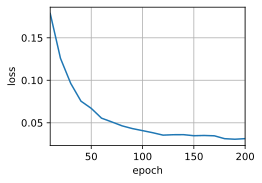

In [42]:
num_hiddens, num_layers, dropout, batch_size, num_steps = 32, 2, 0.1, 64, 10
lr, num_epochs, device = 0.005, 200, try_xpu()
ffn_num_input, ffn_num_hiddens, num_heads = 32, 64, 4 
key_size, query_size, value_size = 32, 32, 32 
norm_shape = [32]

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = TransformerEncoder(len(src_vocab), key_size, query_size, value_size, num_hiddens, norm_shape,
                             ffn_num_input, ffn_num_hiddens, num_heads, num_layers, dropout)
decoder = TransformerDecoder(len(tgt_vocab), key_size, query_size, value_size, num_hiddens, norm_shape,
                             ffn_num_input, ffn_num_hiddens, num_heads, num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [43]:
engs = ['go .', "i lost .", 'he\'s clam .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, bleu {d2l.bleu(translation, fra, k=2):.3f}')

go . => va !, bleu 1.000
i lost . => j'ai perdu ., bleu 1.000
he's clam . => il est <unk> ., bleu 0.658
i'm home . => je suis chez moi ., bleu 1.000


可视化Transformer的注意力权重

In [38]:
enc_attention_weights = torch.cat(net.encoder.attention_weights, 0).reshape((num_layers, num_heads, -1, num_steps))
enc_attention_weights.shape

torch.Size([2, 4, 10, 10])

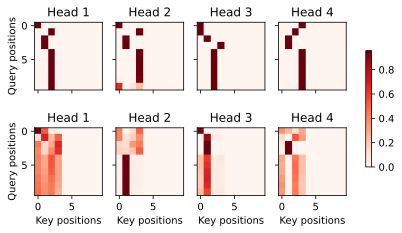

In [ ]:
# 可视化编码器的自注意力权重
d2l.show_heatmaps(enc_attention_weights.cpu(), xlabel='Key positions', ylabel='Query positions',
                  titles=['Head %d' % i for i in range(1, 5)], figsize=(7, 3.5))

In [44]:
dec_attention_weights_2d = [head[0].tolist() for step in dec_attention_weight_seq
                                             for attn in step for blk in attn for head in blk]
# 用零填充被掩蔽的注意力权重
dec_attention_weight_filled = torch.tensor(pd.DataFrame(dec_attention_weights_2d).fillna(0.0).values) 
dec_attention_weights = dec_attention_weight_filled.reshape((-1, 2, num_layers, num_heads, num_steps))
dec_self_attention_weights, dec_inter_attention_weights = dec_attention_weights.permute(1, 2, 3, 0, 4)
dec_self_attention_weights.shape, dec_inter_attention_weights.shape

(torch.Size([2, 4, 6, 10]), torch.Size([2, 4, 6, 10]))

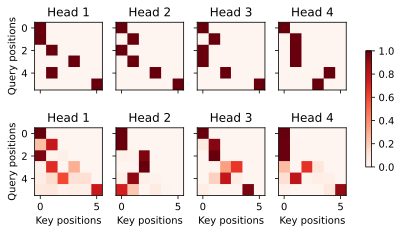

In [45]:
# 可视化解码器自注意力
# Plusonetoinclude the beginning-of-sequencetoken
d2l.show_heatmaps(dec_self_attention_weights[:, :, :, :len(translation.split())+1],
                  xlabel='Key positions', ylabel='Query positions',
                  titles=['Head %d' % i for i in range(1, 5)], figsize=(7, 3.5))

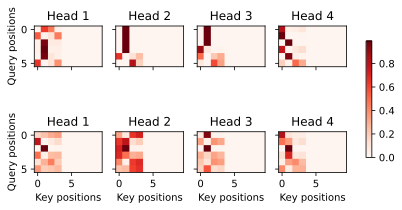

In [46]:
# 可视化编码器-解码器注意力
d2l.show_heatmaps(dec_inter_attention_weights,
                  xlabel='Key positions', ylabel='Query positions',
                  titles=['Head %d' % i for i in range(1, 5)], figsize=(7, 3.5))